In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Esercitazione 8

La mia funzione target è 

$\Psi_T^{\sigma,\mu}(x) = e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}$. 

Io però devo fare sampling Monte Carlo di 

$\rho^{\sigma, \mu} (x)=\frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2}$, 

dove l'integrale al denominatore calcolato a mano (integrale Gaussiano) esce

$\int_{-\infty}^{\infty} dx |\Psi_T(x)|^2 = 2 \sigma \sqrt{\pi} \left( 1+ e^{- \frac{\mu^2}{\sigma^2}} \right) $.

L'obbliettivo è calcolare 

$$
\langle {\hat H} \rangle_T = \int dx \rho^{\sigma, \mu} (x) \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} = \int dx \rho^{\sigma, \mu} (x) \left( x^4 - \frac{5}{2}x^2 + \frac{{-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)} \right) = \int dx \rho^{\sigma, \mu} (x) g^{\sigma, \mu} (x)\, ,
$$

dove 

$$
\frac{\partial^2}{\partial x^2} \Psi_T^{\sigma,\mu}(x) = \frac{1}{\sigma^2}e^{-\frac{(x-\mu)^2}{2\sigma^2}} \left( -1 + \frac{(x-\mu)^2}{\sigma^2}\right) + \frac{1}{\sigma^2}e^{-\frac{(x+\mu)^2}{2\sigma^2}} \left( -1 + \frac{(x+\mu)^2}{\sigma^2}\right)\, .
$$

Il calcolo va fatto con il variational Monte Carlo, i.e., si fa un sampling di $\rho^{\sigma, \mu} (x)$ tramite un normale algoritmo MC (Metropolis), si usano le $x$ così generate per calcolare $g^{\sigma, \mu} (x)$ e poi il valor medio di $g^{\sigma, \mu} (x)$ si interpreta come stima di $\langle {\hat H} \rangle_T$.

Guardando il plot del prof per es 8.1 fisso $\mu=0.85$ e $\sigma=0.65$, mentre l'obbiettivo dell'8.2 è trovare con simulating anniling i valori più opportuni per i due parametri. Considera $\hbar=m=1$.

In [2]:
#codice scritto dal prof

def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

## Esercizio 8.1

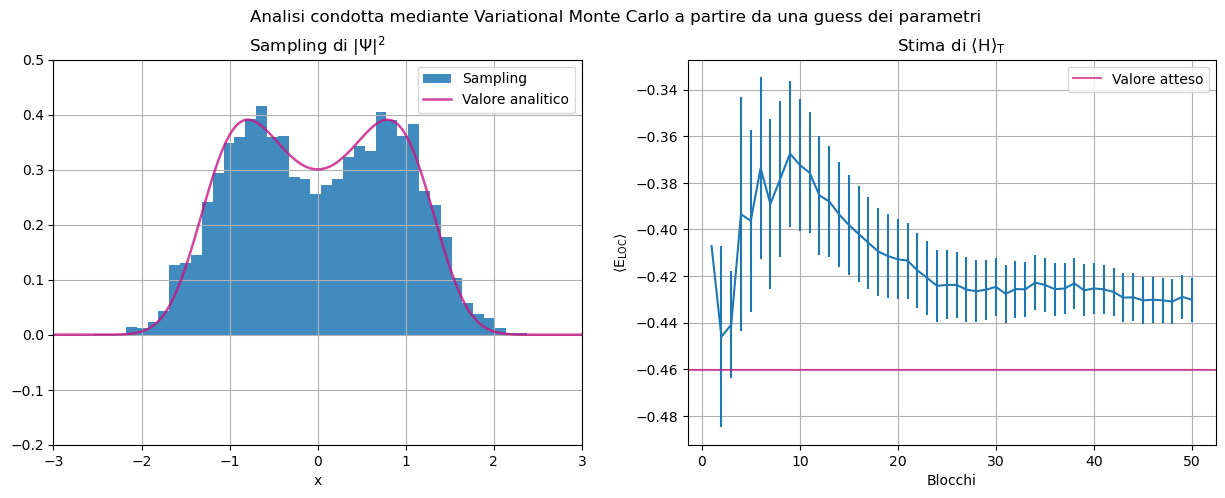

In [3]:
Nle=50  #numero di blocchi
lex=np.arange(Nle)+1  #vettore delle ascisse dei punti plottati

genx=np.loadtxt("genpoints.dat",  unpack="true")
ley, leerrors=np.loadtxt("locenergy.dat", usecols=(0, 1),  unpack="true")  #vettori delle ordinate dei punti plottati e delle barre d'errore

gpfig ,(gpplt1, gpplt2) = plt.subplots(1, 2, figsize=(15, 5))

gpplt1.hist(genx, 40, density=True, label="Sampling", alpha=0.85)
gpplt1.plot(x,(psi[0])**2, color="mediumvioletred", label="Valore analitico", linewidth=1.8, alpha=0.8)
gpplt1.set_title(r"Sampling di $|\Psi|^2$")
gpplt1.set_xlabel("x")
gpplt1.set_xlim((-3,3))
gpplt1.set_ylim((-0.2,0.5))
gpplt1.legend()
gpplt1.grid(True)

gpplt2.errorbar(lex, ley, yerr=leerrors)
gpplt2.axhline(y=-0.46046587969271535, color="mediumvioletred", label="Valore atteso", alpha=0.7)
gpplt2.set_xlabel("Blocchi")
gpplt2.set_ylabel(r"$\left<\mathrm{E_{LOC}}\right>$")
gpplt2.set_title(r"Stima di $\left<\mathrm{H}\right>_\mathrm{T}$")
gpplt2.grid(True)
gpplt2.legend()

gpfig.suptitle("Analisi condotta mediante Variational Monte Carlo a partire da una guess dei parametri")
plt.show()

## Esercizio 8.2

Prendo tot valori di beta, per ognuno faccio genero coppie di parametri che di volta in volta fisso per fare un ciclo di VMC come es 8.1 così uso i valori di energia dell'analisi a blocchi per calcolare il peso di boltzmann che è la distribuzione target del metropolis che genera mu e sigma. Quando cambio beta? Quando per due coppie successive di parametri i valori di energia sono uno a un sigma dall'altro cioè dico ok meglio di così non posso fare. Ogni tot sistemo delta per non avere accettazione bassissima (che comunque non è molto al 50%...). Poi plotto valori di mu e sigma estratti ogni tot, valor medio di energia con errore dell'ultima coppia di mu,sigma generata per un certo beta, analisi a blocchi identica a es 8.1 fatta con i parametri ottimali. Quali sono i parametri ottimali? Quelli che su tutte tutte le coppie di generate minimizzano l'energia media.

In [4]:
#carico tutti i dati
betas, ns=np.loadtxt("beta.dat", usecols=(0, 1),  unpack="true")  #valori di beta analizzati e del numero di step per ognuno dei valori
hs, herrs=np.loadtxt("hstep.dat", usecols=(0, 1),  unpack="true")  #valori di <H> a fisso beta e delle barre d'errore
ts, mus, sigmas=np.loadtxt("params.dat", usecols=(0, 1, 2),  unpack="true")  #valori di sigma per ogni beta e delle barre d'errore
finx=np.loadtxt("finalpoints.dat",  unpack="true")  #sample di |psi|^2 finale
finh, finherrs=np.loadtxt("finalenergies.dat", usecols=(0, 1),  unpack="true")  #analisi a blocchi di <H> con parametri ottimali

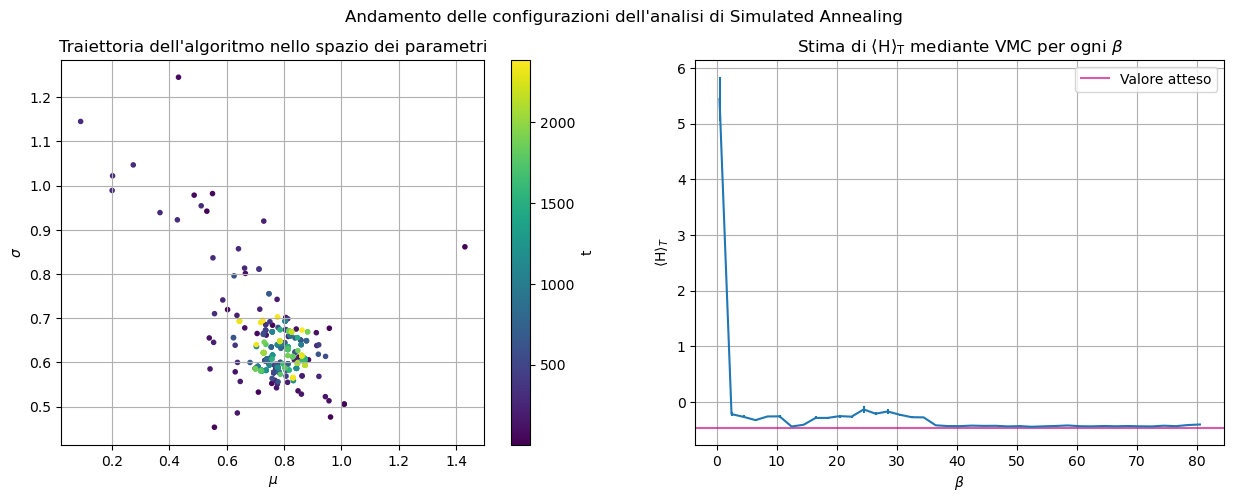

In [5]:
cfig ,(cplt1, cplt2) = plt.subplots(1, 2, figsize=(15, 5))

sc = cplt1.scatter(mus, sigmas, c=ts, cmap="viridis", marker='.')  #guardo l'andamento dell'algoritmo in funzione del tempo praticamente
cbar = cfig.colorbar(sc, ax=cplt1)  
cbar.set_label("t")
cplt1.set_xlabel(r"$\mu$")
cplt1.set_ylabel(r"$\sigma$")
cplt1.set_title("Traiettoria dell'algoritmo nello spazio dei parametri")
cplt1.grid(True)

cplt2.errorbar(betas, hs, yerr=herrs)
cplt2.axhline(y=-0.46046587969271535, color="mediumvioletred", label="Valore atteso", alpha=0.7)
cplt2.set_xlabel(r"$\beta$")
cplt2.set_ylabel(r"$\left<\mathrm{H}\right>_T$")
cplt2.set_title(r"Stima di $\left<\mathrm{H}\right>_\mathrm{T}$ mediante VMC per ogni $\beta$")
cplt2.grid(True)
cplt2.legend()

cfig.suptitle("Andamento delle configurazioni dell'analisi di Simulated Annealing")
plt.show()

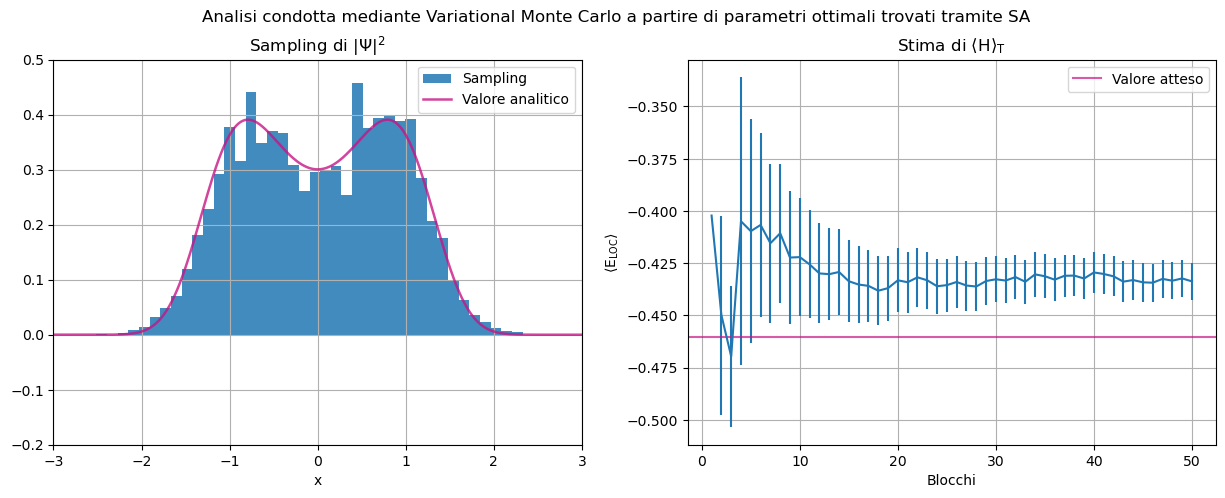

In [6]:
opfig ,(opplt1, opplt2) = plt.subplots(1, 2, figsize=(15, 5))

opplt1.hist(finx, 40, density=True, label="Sampling", alpha=0.85)
opplt1.plot(x,(psi[0])**2, color="mediumvioletred", label="Valore analitico", linewidth=1.8, alpha=0.8)
opplt1.set_title(r"Sampling di $|\Psi|^2$")
opplt1.set_xlabel("x")
opplt1.set_xlim((-3,3))
opplt1.set_ylim((-0.2,0.5))
opplt1.legend()
opplt1.grid(True)

opplt2.errorbar(lex, finh, yerr=finherrs)
opplt2.axhline(y=-0.46046587969271535, color="mediumvioletred", label="Valore atteso", alpha=0.7)
opplt2.set_xlabel("Blocchi")
opplt2.set_ylabel(r"$\left<\mathrm{E_{LOC}}\right>$")
opplt2.set_title(r"Stima di $\left<\mathrm{H}\right>_\mathrm{T}$")
opplt2.grid(True)
opplt2.legend()

opfig.suptitle("Analisi condotta mediante Variational Monte Carlo a partire di parametri ottimali trovati tramite SA")
plt.show()

Mi accontento di compatibilità a tre sigma altrimenti impazzisco :)